In [30]:
import os
import keras
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
classes = ["a", "ai", "chA", "lA", "tA"]

def getHandritingData(folder):
	data = []

	for k in range(5):
		for i in os.listdir(f"./Handwriting_Data/{classes[k]}/{folder}"):

			with open(f"./Handwriting_Data/{classes[k]}/{folder}/{i}") as f:
				coords = np.array([float(x) for x in f.readline().rstrip().split()])

				coordnums = int(coords[0])
				xcoords = coords[1::2]
				ycoords = coords[2::2]

				rangex = max(xcoords) - min(xcoords)
				xcoords = (xcoords - min(xcoords))/rangex		#min-max normalisation

				rangey = max(ycoords) - min(ycoords)
				ycoords = (ycoords - min(ycoords))/rangey

				label = [0, 0, 0, 0, 0]
				label[k] = 1

				letter = [label, coordnums, xcoords, ycoords]
				data.append(letter)
	
	random.shuffle(data)
	return data

In [7]:
train = getHandritingData("train")
test = getHandritingData("dev")

In [10]:
def split(data):
	xdata = []
	ydata = []
	for i in range(len(data)):
		xdata.append(data[i][1:])
		ydata.append(data[i][0])

	return xdata, ydata

In [11]:
xtrain, ytrain = split(train)
xtest, ytest = split(test)

In [12]:
def drawletter(letter):
	plt.plot(letter[1], letter[2], color="black", linewidth=5)
	plt.axis("off")
	plt.show()

In [ ]:
for i in range(5):
	num = 0

	for n in range(len(ytrain)):
		if num == 5:
			break
		if ytrain[n][i] == 1:
			drawletter(xtrain[n])
			num+=1


In [24]:
def TensorConversion(x, y):
	xout = []
	lens = []

	for x_ in x:
		lens.append(x_[0])
		char = np.array([x_[1], x_[2]]).T
		xout.extend(tf.constant(char))
	
	xout = tf.RaggedTensor.from_row_lengths(xout, row_lengths=lens)
	yout = tf.constant(y)

	return xout, yout

In [27]:
xtrain, ytrain = TensorConversion(xtrain, ytrain)
xtest, ytest = TensorConversion(xtest, ytest)

Epoch 1/1000
11/11 - 7s - loss: 1.5728 - accuracy: 0.2023 - 7s/epoch - 630ms/step
Epoch 2/1000
11/11 - 6s - loss: 1.4959 - accuracy: 0.2283 - 6s/epoch - 540ms/step
Epoch 3/1000
11/11 - 6s - loss: 1.4631 - accuracy: 0.3931 - 6s/epoch - 549ms/step
Epoch 4/1000
11/11 - 6s - loss: 1.4294 - accuracy: 0.4711 - 6s/epoch - 535ms/step
Epoch 5/1000
11/11 - 6s - loss: 1.2379 - accuracy: 0.5318 - 6s/epoch - 533ms/step
Epoch 6/1000
11/11 - 6s - loss: 1.0475 - accuracy: 0.5723 - 6s/epoch - 544ms/step
Epoch 7/1000
11/11 - 6s - loss: 0.8456 - accuracy: 0.6676 - 6s/epoch - 529ms/step
Epoch 8/1000
11/11 - 6s - loss: 0.7582 - accuracy: 0.7601 - 6s/epoch - 513ms/step
Epoch 9/1000
11/11 - 6s - loss: 0.6850 - accuracy: 0.7717 - 6s/epoch - 503ms/step
Epoch 10/1000
11/11 - 6s - loss: 0.5889 - accuracy: 0.8237 - 6s/epoch - 535ms/step
Epoch 11/1000
11/11 - 6s - loss: 0.5869 - accuracy: 0.7948 - 6s/epoch - 518ms/step
Epoch 12/1000
11/11 - 6s - loss: 0.6446 - accuracy: 0.7803 - 6s/epoch - 529ms/step
Epoch 13/1000

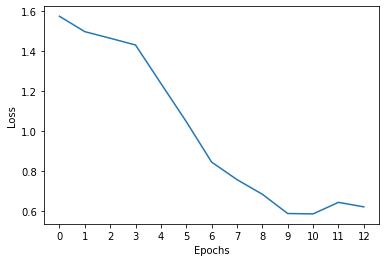

Train Accuracy: 0.7485549132947977
Confusion Matrix
[[63  6  0  0  0]
 [ 4 66  0  0  0]
 [19  0 43  5  3]
 [16  0  2 43  7]
 [10  0  0 10 49]]

Test Accuracy: 0.91
Confusion Matrix
[[19  1  0  0  0]
 [ 1 19  0  0  0]
 [ 4  0 15  1  0]
 [ 2  0  0 18  0]
 [ 0  0  0  0 20]]


In [33]:
model = keras.Sequential()
model.add(keras.layers.LSTM(128, return_sequences=True, batch_input_shape=(None, None, 2)))
model.add(keras.layers.LSTM(32, return_sequences=False))
model.add(keras.layers.Dense(5, activation='softmax', name="OutputLayer"))


es = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1E-4, verbose=2, patience=2)
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(xtrain, ytrain, verbose=2, epochs=1000, callbacks=[es])


plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xticks(range(len(history.history["loss"])))
plt.show()

trainpred = model.predict(xtrain)
trainpred = np.rint(trainpred)
print("Train Accuracy:", accuracy_score(ytrain, trainpred))
print("Confusion Matrix")
print(confusion_matrix(tf.argmax(ytrain, axis=1), tf.argmax(trainpred, axis=1)))

testpred = model.predict(xtest)
testpred = np.rint(testpred)
print("\nTest Accuracy:", accuracy_score(ytest, testpred))
print("Confusion Matrix")
print(confusion_matrix(tf.argmax(ytest, axis=1), tf.argmax(testpred, axis=1)))